<a href="https://colab.research.google.com/github/Pludaggerto/LearnAndTest/blob/main/code/demoMCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 MCMC

MCMC方法是用来在概率空间，**通过随机采样估算兴趣参数**的后验分布。



## 1.1 动机
- 解决概率密度函数不可积以及累积分布函数没有反函数时的应用
    - 反函数是因为MC中，用均匀分布计算F(x)，然后求解$x_i = F^{-1}(i)$
- 解决维数灾难



# 2 蒙特卡罗



## 2.1 Box-Muller变换
正态分布可由随机分布生成

NormaltestResult(statistic=3.755000254631634, pvalue=0.1529720387872138)

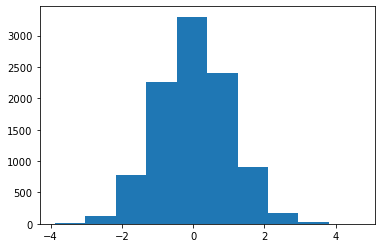

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
a = np.random.uniform(0,1,(10000))
b = np.random.uniform(0,1,(10000))
z = np.sqrt(-2*np.log(a)) * np.cos(2* np.pi * b)
plt.hist(z)
scipy.stats.normaltest(z)

## 2.2 拒绝接受采样
- 需求： 根某已知分布的概率密度函数$f(x)$，产生服从此分布的样本$X$。
- 准备
    - 需要辅助的建议分布$G$
    - 辅助的均匀分布$U(0,1)$
    - 计算常数$c$，使得$cg(x) \geq f(x)$的最小值
- 过程
    - 从建议分布$G$抽样，得到样本$Y$
    - 从$U(0,1)$抽样，得到样本$D$
    - 如果$D \leq \frac{f(Y)}{c * g(Y)}$，则令$X = Y$(接受Y)，否则继续执行步骤1（拒绝）。

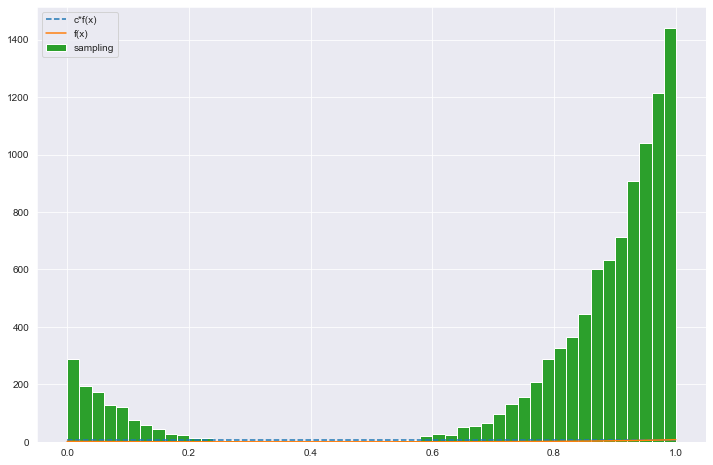

In [ ]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


def AceeptReject(split_val):
    global c
    global power
    while True:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        if y*c <= math.pow(x - split_val, power):
            return x

power = 4
t = 0.4  
sum_ = (math.pow(1-t, power + 1) - math.pow(-t, power + 1)) / (power + 1)  #求积分
x = np.linspace(0, 1, 100)
#常数值c
c = 0.6**4/sum_
cc = [c for xi in x]
plt.plot(x, cc, '--',label='c*f(x)')
#目标概率密度函数的值f(x)
y = [math.pow(xi - t, power)/sum_ for xi in x]
plt.plot(x, y,label='f(x)')
#采样10000个点
samples = []
for  i in range(10000):
    samples.append(AceeptReject(t))
plt.hist(samples, bins=50,label='sampling')
plt.legend()
plt.show()

## 2.3 蒙特卡罗方法小结
使用接受-拒绝采样，我们可以解决一些概率分布不是常见的分布的时候，得到其采样集并用蒙特卡罗方法求和得到。但是接受-拒绝采样也只能部分满足我们的需求，在很多时候我们还是很难得到我们的概率分布的样本集。比如之前的第一个问题有时可以解决，但又会产生另一个问题：

- 对于一些二维分布$p(x, y)$，我们只能得到条件分布$p(x|y)，p(y|x)$，却不能得到二维分布的一般形式；

- 对于复杂非常见分布$p(x_1,..., x_n)$，我们很难找到合适的$q(x),c$，

要想将蒙特卡罗方法作为一个通用的采样模拟求和的方法，还需马尔科夫链的帮忙。

# 3 马尔可夫链
马尔科夫链定义本身比较简单，它假设某一时刻状态转移的概率只依赖于它的前一个状态。

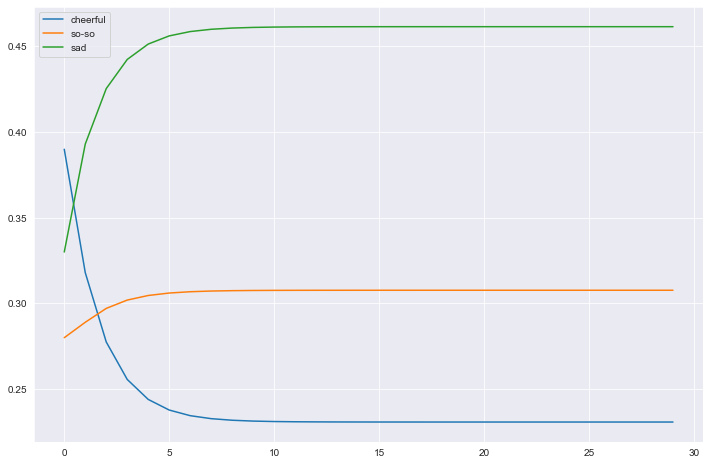

In [ ]:
transfer_matrix = np.array([[0.6,0.2,0.2],[0.3,0.4,0.3],[0,0.3,0.7]],dtype='float32')
start_matrix = np.array([[0.5,0.3,0.2]],dtype='float32')

value1 = []
value2 = []
value3 = []
for i in range(30):
    start_matrix = np.dot(start_matrix,transfer_matrix)
    value1.append(start_matrix[0][0])
    value2.append(start_matrix[0][1])
    value3.append(start_matrix[0][2])

x = np.arange(30)
plt.plot(x,value1,label='cheerful')
plt.plot(x,value2,label='so-so')
plt.plot(x,value3,label='sad')
plt.legend()
plt.show()

马尔科夫链模型的状态转移矩阵收敛到的稳定概率分布与我们的初始状态概率分布无关。也就是说，如果我们得到了这个稳定概率分布对应的马尔科夫链模型的状态转移矩阵，则我们可以用任意的概率分布样本开始，带入马尔科夫链模型的状态转移矩阵，这样经过一些序列的转换，最终就可以得到符合对应稳定概率分布的样本。
## 3.1 平稳分布
平稳分布：经过一步概率转移后分布保持不变
$$
\pi  = \pi P
$$
对于一个不可约的马尔可夫链，如果是遍历的，那么任何初始状态在足够长的时间后，都会变成平稳分布。



## 3.2 马尔可夫链采样MCMC
### 3.2.1 原理
提高了采样的效率。
对于随机矩阵$Q$，引入$\alpha$，使得
$$
\pi(i) = Q(i,j) \alpha(i,j)
$$
与MC采样类似，通过随机转移矩阵$Q$进行采样，但是样本被保留下来继续抽样的概率为$\alpha$。
$$
\alpha(i, j)=\min \left\{\frac{\pi(j) Q(j, i)}{\pi(i) Q(i, j)}, 1\right\}\
$$

### 3.2.2步骤
- 给定转移矩阵$Q$，平稳分布$\pi(x)$
- t=0随机产生一个初始状态$x_0$
- 从条件概率分布$Q(x|x_0)$中采样$x^*$
- 从均匀分布产生u~U(0,1)
- 若$u < \alpha(x_0, x^*) = \min {\frac{\pi(j) Q(j, i)}{\pi(i)Q(i, j)}}$，接受$x^* \rightarrow t = 1, x_1 = x^*$，否则拒绝该次采样，$t = 1, x_1 = x_0$
- 继续以上步骤，直到$t>T$时，达到平衡。
- t > T 之后所有接受样本即需要的平稳分布样本


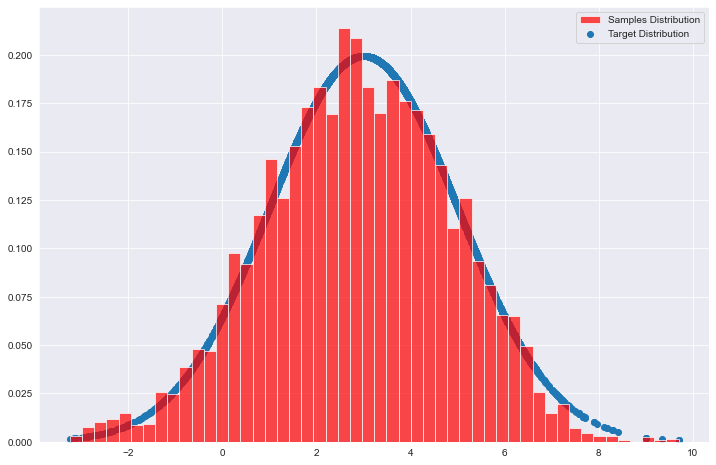

In [ ]:
from scipy.stats import norm

def norm_dist_prob(theta):
    y = norm.pdf(theta, loc=3, scale=2)
    return y

T = 5000
pi = [0 for i in range(T)]
sigma = 1
t = 0
while t < T-1:
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = min(1, (norm_dist_prob(pi_star[0]) / norm_dist_prob(pi[t - 1])))   #alpha值

    u = random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]


plt.scatter(pi, norm.pdf(pi, loc=3, scale=2),label='Target Distribution')
num_bins = 50
plt.hist(pi, num_bins, density=1, stacked=True, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

## 3.3吉布斯采样
### 3.3.1 原理
解决在高维参数空间上，接受概率过小的问题。
### 3.3.2 步骤
- 给定平稳分布 $\pi(x_1,x_2)$
- $t = 0$随机产生一个初始状态$(x_1^{(0)}, x_2^{(0)})$
- 从条件概率分布$P(x_2|x_1^{0})$中采样$(x_1^{0}, x_2^{1})$
- 从条件概率分布$P(x_1|x_2{(1)})$中采样$(x_1^{1}, x_2^{1})$
- 不停轮换坐标轴，采取指定数量样本为止。

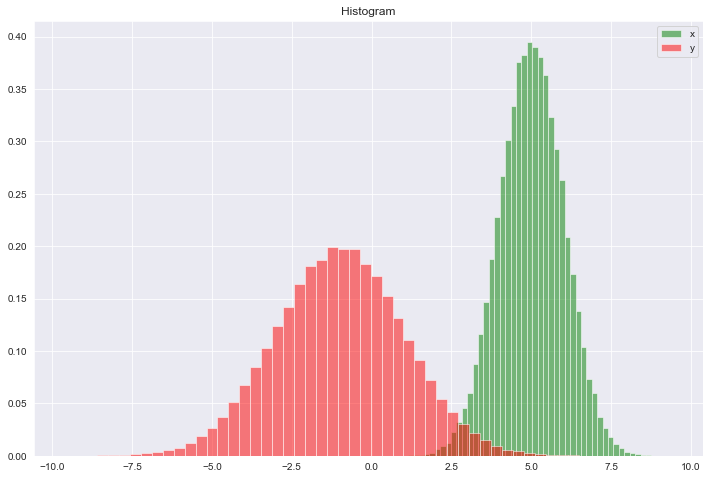

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

samplesource = multivariate_normal(mean=[5,-1], cov=[[1,0.5],[0.5,2]])

def p_ygivenx(x, m1, m2, s1, s2):
    return (random.normalvariate(m2 + rho * s2 / s1 * (x - m1), math.sqrt(1 - rho ** 2) * s2))

def p_xgiveny(y, m1, m2, s1, s2):
    return (random.normalvariate(m1 + rho * s1 / s2 * (y - m2), math.sqrt(1 - rho ** 2) * s1))

N = 5000
K = 20
x_res = []
y_res = []
z_res = []
m1 = 5
m2 = -1
s1 = 1
s2 = 2

rho = 0.5
y = m2

for i in range(N):
    for j in range(K):
        x = p_xgiveny(y, m1, m2, s1, s2)   #y给定得到x的采样
        y = p_ygivenx(x, m1, m2, s1, s2)   #x给定得到y的采样
        z = samplesource.pdf([x,y])
        x_res.append(x)
        y_res.append(y)
        z_res.append(z)

num_bins = 50
plt.hist(x_res, num_bins, density=1, stacked=True, facecolor='green', alpha=0.5,label='x')
plt.hist(y_res, num_bins, density=1, stacked=True, facecolor='red', alpha=0.5,label='y')
plt.title('Histogram')
plt.legend()
plt.show()

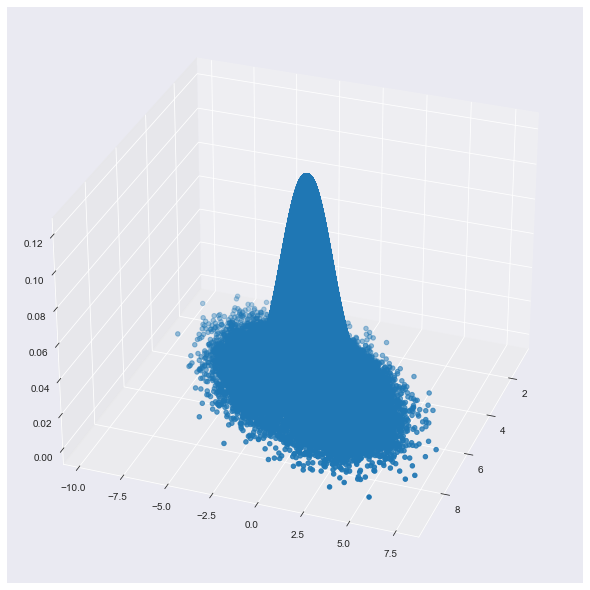

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
ax.scatter(x_res, y_res, z_res,marker='o')
plt.show()

# 4 应用



## 4.1 计算圆周率
$$
f(x) = \sqrt{1 - x^2} \Leftrightarrow \\
\pi = 4 \int^1_{0}f(x)\mathrm{dx} 
$$
假设$X\text{~}U(0,1),Y\text{~}U(0,1)$，计算$y \leq f(x)$的概率。

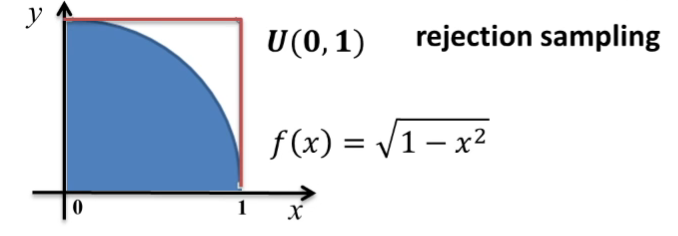

In [ ]:
import random 

def cal_pi(N): 
  for i in range(N):
    x = random.random()
    y = random.random()
    if x**2 + y ** 2 <= 1: 
      count +=1
    return 4 * count / N
    
cal_pi(1000000)